# 00_preprocess.ipynb
### Preprocess Gridded Data to find Anomalies 

This notebook preprocess gridded sea surface temperature (SST) data to extract anomalies and saves a land mask.

We use monthly mean SST from the [NOAA Optimum Interpolation Sea Surface Temperature](https://www.ncdc.noaa.gov/oisst/data-access) (OISST v2.1) dataset available on S3 compatible object storage.  This data is measured from a blend of satellite and in-situ observations. We elect to use data from AVHRR-only satellites. This product is available from September 1981 through present on a 1/4º global regular grid.

![preprocess_flow](images/00_preprocess.png)


In [3]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Import data
- load the daily OISST dataset and resample to monthly means


In [4]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True).resample(time='MS').mean()

In [5]:
da = ds.sst.isel(zlev=0)
da.load();

/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### Transform time into decimal year and add it as a new coordinate --> `da.dyr`

In [6]:
years = pd.DatetimeIndex(da.time.values).year
months = pd.DatetimeIndex(da.time.values).month
dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12)
    dyr.append(I)
dyr = np.array(dyr)

#### Decompose SST fields into mean, trend, annual, and semi-annual harmonics


In [8]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':da.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':da.time.values})  

# resulting coefficients of the model
sst_mod = pmodel_da.dot(da) #xr.DataArray(pmodel_da.dot(da), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':da.lat.values, 'lon':da.lon.values})  


In [13]:
# Construct mean, trend, and seasonal cycle
mean = model_da[:,0].dot(sst_mod[0,:,:])
trend = model_da[:,1].dot(sst_mod[1,:,:])
seas = model_da[:,2:].dot(sst_mod[2:,:,:])

#### Get the SST anomalies with and without the trend

In [14]:
# redefine SST with and without the trend
sst_notrend = xr.DataArray((da-trend).values, dims=['time','lat','lon'], coords={'time':ds.time, 'lat':ds.lat.values, 'lon':ds.lon.values})  
sst_trend = da

# compute anomalies (SSTa) by removing model coefficients – with and without the trend
ssta_notrend = da-model_da.dot(sst_mod)
ssta_trend = da-model_da.dot(sst_mod[[0,2,3,4,5],:,:])

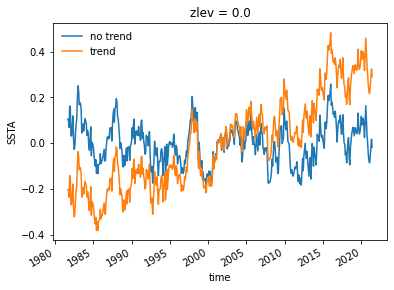

In [19]:
# Plot weighted global mean timeseries of SSTA with and without trend
dlon = np.cos(da.lat * np.pi/180) *111e3
dlat = 111e3 * xr.ones_like(da.lon)
cell_area = dlon * dlat

ssta_notrend.weighted(cell_area).mean(('lat','lon')).plot(label='no trend')
ssta_trend.weighted(cell_area).mean(('lat','lon')).plot(label='trend')
plt.legend(frameon=False); plt.ylabel('SSTA');

#### Add a landmask

In [18]:
path = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/lsmask.oisst.nc'
ds_mask = xr.open_dataset(path, use_cftime=True) 
lsmask = ds_mask.lsmask.isel(time=0)

#### Save SSTA to netCDF

In [20]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(
        lsmask=(['lat', 'lon'], lsmask.data),
        ssta_notrend=(['time', 'lat', 'lon'], ssta_notrend.data),
        ssta_trend=(['time', 'lat', 'lon'], ssta_trend.data),
        mean = (['time', 'lat', 'lon'], mean.data),
        trend = (['time', 'lat', 'lon'], trend.data),
        seas = (['time', 'lat', 'lon'], seas.data),
             
    ),
    coords=dict(
        time=(['time'], da.time.data),
        lat=(['lat'], da.lat.data),
        lon=(['lon'], da.lon.data),
    ),
    attrs=dict(description="preprocessed monthly averaged OISST v2.1 anomalies"),
)


ds_new.to_netcdf(path+'preprocessed_OISSTv21.nc', mode='w')
